In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, losses
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model

import warnings
warnings.filterwarnings('ignore')

2024-07-23 13:03:23.452695: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 13:03:23.527199: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-23 13:03:23.552169: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-23 13:03:23.661842: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-23 13:03:24.954147: W tensorflow/compiler/tf2

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

I0000 00:00:1721732606.593148  402459 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721732606.702335  402459 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721732606.702779  402459 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [3]:
data = pd.read_csv("times_series_data_no_labels.csv" ,
    index_col='datetime',
    parse_dates=['datetime']
    )

data.describe()

,data_0,data_1
count,51840.000000,51840.000000
mean,27.428187,27.427566
std,4.276855,4.281787
min,16.042714,16.342305
25%,23.792250,23.832418
50%,29.712173,29.709107
75%,30.188862,30.189345
max,41.066048,41.122645


In [4]:
train_size = int(len(data) * 0.85)
test_size = len(data) - train_size
train, test = data.iloc[0:train_size], data.iloc[train_size:len(data)]

print(train.shape, test.shape)

# # Standardize the data
# scaler = StandardScaler()
# scaler.fit(train[['data_0']])

# # Transform and explicitly cast to float64
# train_transformed = scaler.transform(train[['data_0']]).astype('float64')
# test_transformed = scaler.transform(test[['data_0']]).astype('float64')

# Assign the transformed values back to the DataFrame
train = pd.DataFrame(train, columns=['data_0'])
test = pd.DataFrame(test, columns=['data_0'])

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

(44064, 2) (7776, 2)


In [5]:
TIME_STEPS = 288

X_train, _ = create_dataset(train[['data_0']], train.data_0, TIME_STEPS)
X_test, _ = create_dataset(test[['data_0']], test.data_0, TIME_STEPS)

min = tf.reduce_min(X_train)
max = tf.reduce_max(X_test)

#Now we will use the formula (data - min)/(max - min)
train_data = (X_train - min)/(max - min)
test_data = (X_test - min)/(max - min)

#I have converted the data into float
train_data = tf.cast(train_data, dtype=tf.float32)
test_data = tf.cast(test_data, dtype=tf.float32)    

I0000 00:00:1721732608.239281  402459 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721732608.251161  402459 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721732608.251510  402459 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721732608.480519  402459 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [6]:

class detector(Model):
    def __init__(self):
        super(detector, self).__init__()
        self.encoder = tf.keras.Sequential([
                                            layers.Dense(64, activation='relu'),
                                            layers.Dense(32, activation='relu'),
                                            layers.Dense(8, activation='relu')
        ])
        self.decoder = tf.keras.Sequential([
                                            layers.Dense(16, activation='relu'),
                                            layers.Dense(32, activation='relu'),
                                            layers.Dense(288, activation='sigmoid')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


### In the reference he trained the model, with non-anomalous data

In [7]:
with tf.device('/CPU:0'):
    autoencoder = detector()
    autoencoder.compile(optimizer='adam', loss='mae')
    autoencoder.fit(train_data, train_data, epochs=5, batch_size=256, validation_data=(test_data, test_data))

Epoch 1/5


I0000 00:00:1721732610.419910  403029 service.cc:146] XLA service 0x7ddd78031d90 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721732610.419954  403029 service.cc:154]   StreamExecutor device (0): Host, Default Version
2024-07-23 13:03:30.473736: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


  1/171 ━━━━━━━━━━━━━━━━━━━━ 6:16 2s/step - loss: 0.3316

I0000 00:00:1721732611.177454  403029 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


171/171 ━━━━━━━━━━━━━━━━━━━━ 32s 177ms/step - loss: 0.2703 - val_loss: 0.1106
Epoch 2/5
171/171 ━━━━━━━━━━━━━━━━━━━━ 30s 174ms/step - loss: 0.0734 - val_loss: 0.0066
Epoch 3/5
171/171 ━━━━━━━━━━━━━━━━━━━━ 30s 175ms/step - loss: 0.0076 - val_loss: 0.0034
Epoch 4/5
171/171 ━━━━━━━━━━━━━━━━━━━━ 30s 175ms/step - loss: 0.0050 - val_loss: 0.0031
Epoch 5/5
171/171 ━━━━━━━━━━━━━━━━━━━━ 29s 169ms/step - loss: 0.0047 - val_loss: 0.0043


2024-07-23 13:06:04.018213: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2484338688 exceeds 10% of free system memory.


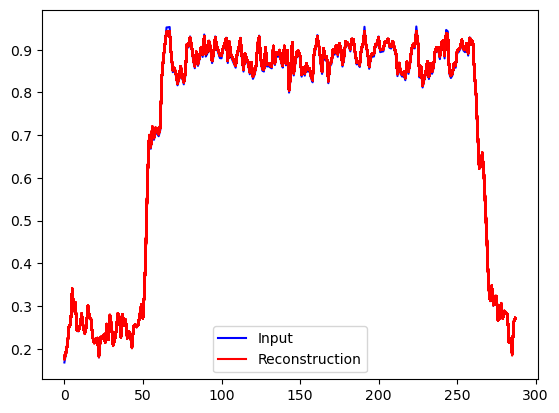

In [8]:
def plot(data, n, batch_size=32):
    # Process data in batches to reduce memory usage
    num_samples = data.shape[0]
    enc_img = []
    dec_img = []
    
    for i in range(0, num_samples, batch_size):
        batch_data = data[i:i + batch_size]
        batch_enc = autoencoder.encoder(batch_data)
        batch_dec = autoencoder.decoder(batch_enc)
        enc_img.append(batch_enc)
        dec_img.append(batch_dec)
    
    enc_img = tf.concat(enc_img, axis=0)
    dec_img = tf.concat(dec_img, axis=0)

    # Plot the original and reconstructed data for sample n
    plt.plot(data[n], 'b')
    plt.plot(dec_img[n], 'r')
    plt.legend(labels=['Input', 'Reconstruction'])
    plt.show()

# Plot the results for a test data sample
with tf.device('/CPU:0'):
    plot(test_data, 0)

In [9]:
from tensorflow.keras import backend as K
K.clear_session()

In [10]:
with tf.device('/CPU:0'):
    reconstructed = autoencoder(train_data)
    train_loss = losses.mae(train_data, reconstructed)
    t = np.mean(train_loss.numpy()) + np.std(train_loss.numpy())
def prediction(model, data, threshold):
  with tf.device('/CPU:0'):
    rec = model.predict(data, batch_size=32)
    loss = losses.mae(data, rec)
    return tf.math.less(loss, threshold)

2024-07-23 13:06:07.366216: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3227516928 exceeds 10% of free system memory.
2024-07-23 13:06:07.884330: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3227516928 exceeds 10% of free system memory.
2024-07-23 13:06:10.722894: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3227516928 exceeds 10% of free system memory.
2024-07-23 13:06:11.431617: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1613758464 exceeds 10% of free system memory.


In [ ]:

pred = prediction(autoencoder, train_data, t)
print(pred)

1368/1368 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
